# Predict Hazard Ratings for a Maintenance Project

## Feature Selection

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats, spearmanr, mannwhitneyu
from pingouin import kruskal
import scikit_posthocs as sp

In [10]:
hz_train = pd.read_csv(r'C:\Users\a.vijaykumar.satpute\Documents\Edvancer\Project4\Hazard_train.csv')
hz_test = pd.read_csv(r'C:\Users\a.vijaykumar.satpute\Documents\Edvancer\Project4\Hazard_test_share.csv')

> Correlation Matrix for Numerical Variables

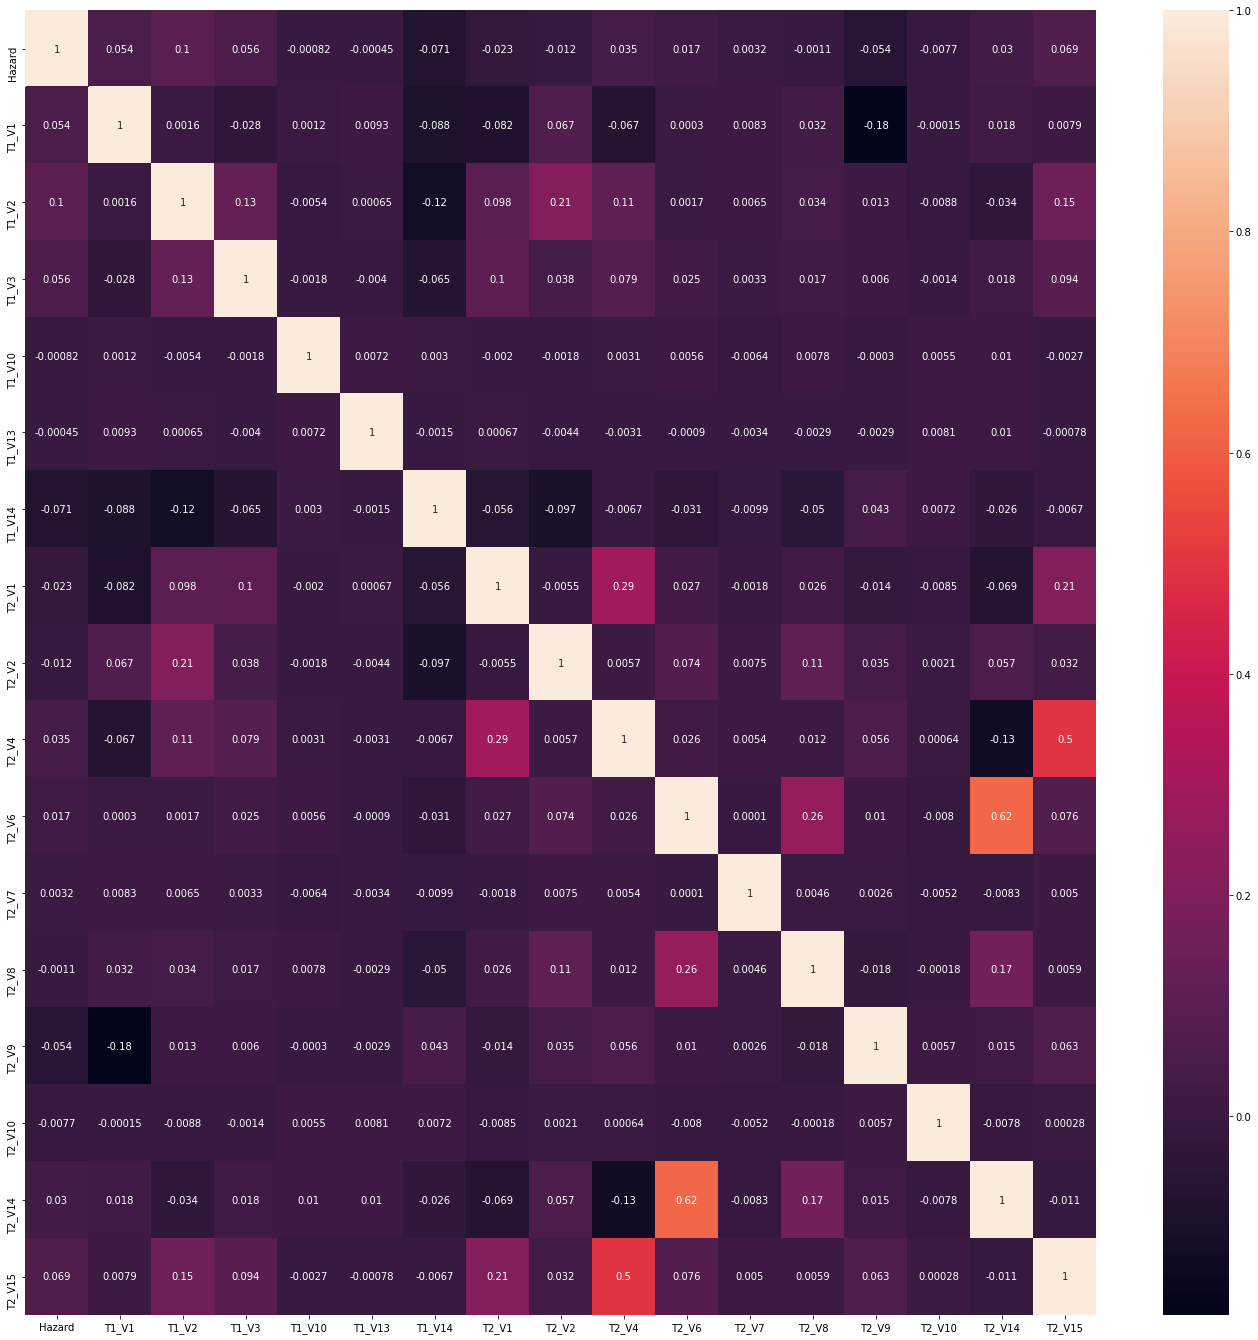

In [11]:
hz_train.drop('Id', axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(24,24))

ax = sns.heatmap(hz_train.corr(), annot=True)

> From the correlation matrix T2_V4 and T2_V15 has correlation coeff. of 0.5 and T2_V6 and T2_V14 has correlation coeff. of 0.62. We can drop one of the two varaibles in each pair. Let's examine with more statistical tests.


### Spearman Correlation Test
> Most of the numerical Independent variables are ordinal in nature and the Dependent(Response) variable is rank ordered already and it is right skewed(non-parametric distribution) we will apply Spearman correlation Test to check the strength of association between IV and DV.

In [17]:
num_col = hz_train.select_dtypes(include='integer').columns.to_list()
num_col = set(num_col) - {'Id', 'Hazard'}
num_col
data = []
columns = ['Variable','Coef', 'P-Value', 'Significance']
for col in num_col:
    coef, p = spearmanr(hz_train[col], hz_train['Hazard'])
    alpha = 0.05
    if p < alpha:
        s = 'Dependent'
    else:
        s= 'Independent'
    data.append([col, coef, p, s])
    
Spearman_test_Table =pd.DataFrame(data, columns=columns)
Spearman_test_Table

,Variable,Coef,P-Value,Significant
0,T1_V1,0.025491,2.611151e-07,Dependent
1,T2_V4,0.043355,1.933291e-18,Dependent
2,T2_V6,0.017915,2.959981e-04,Dependent
3,T1_V2,0.121517,5.257994e-134,Dependent
4,T2_V9,-0.050756,1.085392e-24,Dependent
5,T2_V1,-0.005366,2.784303e-01,Independent
6,T2_V10,-0.006523,1.876658e-01,Independent
7,T2_V14,0.019807,6.309047e-05,Dependent
8,T1_V10,0.001380,7.803884e-01,Independent
9,T2_V15,0.075667,7.060106e-53,Dependent


> From above Spearman table we can see IV T2_V1, T2_V10, T1_V10, T1_V13, T2_V7, T2_V8 has very weak correlation coefficient with DV(Hazard) and they doesn't explain much variance in the DV.

### Kruskal Wallis Test
> It is a nonparametric test we are using to understand the relation between categorical IV (2 or more than 2 levels) and Ordinal DV(Hazard).

In [29]:
cat_col = hz_train.select_dtypes(include='object').columns.to_list()
data1=[]
cols=['variable', 'H', 'P-Value', 'Significant']

for col in cat_col:
    kruskal_df = kruskal(data=hz_train, dv='Hazard', between=col)
    alpha=0.05
    if kruskal_df['p-unc'].values < alpha:
        s = 'Dependent'
    else:
        s= 'Independent'
    data1.append([col, kruskal_df['H'].values, kruskal_df['p-unc'].values,s])
        
Kruskal_test_Table = pd.DataFrame(data1, columns=cols)
Kruskal_test_Table

,variable,H,P-Value,Significant
0,T1_V4,[392.7449046201761],[8.574101814596845e-81],Dependent
1,T1_V5,[696.4971682166297],[3.9165551785426656e-144],Dependent
2,T1_V6,[0.06629012745464538],[0.7968169808367022],Independent
3,T1_V7,[84.82000652242562],[2.836556179345087e-18],Dependent
4,T1_V8,[404.60647550825325],[2.2250822642535874e-87],Dependent
5,T1_V9,[650.4165911135321],[2.5729989044860318e-138],Dependent
6,T1_V11,[752.1020060736182],[3.614866933465681e-154],Dependent
7,T1_V12,[259.60758199158215],[5.466280531668472e-56],Dependent
8,T1_V15,[539.7314850659566],[2.2862160589045276e-112],Dependent
9,T1_V16,[838.5108663678421],[2.8112228459180187e-167],Dependent


> From above Kruskal Wallis Table, IVs T1_V6, T1_V17, T2_V3, T2_V11, T2_V12 has the low H statistics and weak relationsip with DV(Hazard), so we can exclude these variables in model building.
Also, to indicate how strong the effect of IV on DV we will calculate effect size using Epsilon Square Method (H * (n+1)/(n**2 -1))

In [37]:
crosstable = pd.crosstab(hz_train['Hazard'],hz_train['T1_V4'])
n = crosstable.sum().sum() #Total no. of cases, It will be same for all IV 
print(n)

cat_col = hz_train.select_dtypes(include='object').columns.to_list()
data1=[]
cols=['variable', 'H', 'P-Value', 'Significant','Effect Size']

for col in cat_col:
    kruskal_df = kruskal(data=hz_train, dv='Hazard', between=col)
    alpha=0.05
    if kruskal_df['p-unc'].values < alpha:
        s = 'Dependent'
    else:
        s= 'Independent'
    effect_size = kruskal_df['H'].values * (n + 1)/(n**2 - 1)
    data1.append([col, kruskal_df['H'].values, kruskal_df['p-unc'].values,s,effect_size.round(2)])
        
Kruskal_test_Table = pd.DataFrame(data1, columns=cols)
Kruskal_test_Table

40799


,variable,H,P-Value,Significant,Effect Size
0,T1_V4,[392.7449046201761],[8.574101814596845e-81],Dependent,[0.01]
1,T1_V5,[696.4971682166297],[3.9165551785426656e-144],Dependent,[0.02]
2,T1_V6,[0.06629012745464538],[0.7968169808367022],Independent,[0.0]
3,T1_V7,[84.82000652242562],[2.836556179345087e-18],Dependent,[0.0]
4,T1_V8,[404.60647550825325],[2.2250822642535874e-87],Dependent,[0.01]
5,T1_V9,[650.4165911135321],[2.5729989044860318e-138],Dependent,[0.02]
6,T1_V11,[752.1020060736182],[3.614866933465681e-154],Dependent,[0.02]
7,T1_V12,[259.60758199158215],[5.466280531668472e-56],Dependent,[0.01]
8,T1_V15,[539.7314850659566],[2.2862160589045276e-112],Dependent,[0.01]
9,T1_V16,[838.5108663678421],[2.8112228459180187e-167],Dependent,[0.02]


> An epsilon square of 0 would mean no differences (and no influence), while one of 1 would indicate a full dependency. We can use below table to determine the strength of dependecy.
0.00 < 0.01 - Negligible
0.01 < 0.04 - Weak
0.04 < 0.16 - Moderate
0.16 < 0.36 - Relatively strong
0.36 < 0.64 - Strong
0.64 < 1.00 - Very strong
Most of the IV has weak or negligible dependency. We will be excluding variables with effect size negligible and considering T1_V5, T1_V9, T1_V11, T1_V16 for model building.

> The Kruskal-Wallis test, shows whether the IV has significant impact on DV. If we want to check, whether there is significant difference in the levels of given categorical variables, we can use post-hoc test. This will help us for dummy encoding of categorical variables, as we will get to know which levels actully explains the variance in response variable.

In [45]:
ph_T1_V5 = sp.posthoc_dunn(hz_train, val_col='Hazard', group_col='T1_V5', p_adjust='bonferroni')
print('ph_T1_V5','\n',ph_T1_V5)

ph_T1_V9 = sp.posthoc_dunn(hz_train, val_col='Hazard', group_col='T1_V9', p_adjust='bonferroni')
print('ph_T1_V9','\n',ph_T1_V9)

ph_T1_V11 = sp.posthoc_dunn(hz_train, val_col='Hazard', group_col='T1_V11', p_adjust='bonferroni')
print('ph_T1_V11','\n',ph_T1_V11)

ph_T1_V16 = sp.posthoc_dunn(hz_train, val_col='Hazard', group_col='T1_V16', p_adjust='bonferroni')
print('ph_T1_V16','\n',ph_T1_V8)


ph_T1_V5 
                A             B             C             D    E             H  \
A   1.000000e+00  5.103268e-29  1.672450e-09  3.513978e-07  1.0  3.552030e-27   
B   5.103268e-29  1.000000e+00  1.576400e-08  1.354734e-01  1.0  8.832331e-03   
C   1.672450e-09  1.576400e-08  1.000000e+00  2.152694e-04  1.0  1.025696e-02   
D   3.513978e-07  1.354734e-01  2.152694e-04  1.000000e+00  1.0  4.125810e-03   
E   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.0  1.000000e+00   
H   3.552030e-27  8.832331e-03  1.025696e-02  4.125810e-03  1.0  1.000000e+00   
I   1.116087e-43  1.000000e+00  7.430217e-15  3.560194e-01  1.0  1.212815e-06   
J   9.719440e-01  1.000000e+00  1.000000e+00  2.244739e-01  1.0  1.000000e+00   
K  8.109591e-130  8.830115e-04  1.555792e-49  1.000000e+00  1.0  1.013029e-31   
L   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.0  1.000000e+00   

              I         J              K    L  
A  1.116087e-43  0.971944  8.109591e-130  1.0  
B

> From abpve post-hoc test, we will dummy encode categories which are significantly different.
T1_V5 - A	B	C	H	K
T1_V9 - B	D	E
T1_V11 - A	E
T1_V16 - A	D

> From the test performed above we will be dropping below variables in the feature transformation and model building.
'Id','T1_V4', 'T1_V8','T1_V15','T1_V3','T1_V6','T1_V7','T1_V12',
              'T1_V17','T2_V5','T2_V13', 'T2_V3','T2_V11','T2_V12',
               'T1_V10','T1_V13','T2_V1','T2_V7','T2_V8','T2_V10'